In [7]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sharedcontrolpaper.force_sensitive_stopping_task_utils import plot_trial_pressure_individual

In [8]:
parent_directory = os.path.dirname(os.getcwd())
%store -r merged_df
%store -r duration_of_inhibition
%store -r shared_control_metrics

In [9]:
warnings.filterwarnings('ignore') # Ignore warnings

## Figure 2: A canonical trial

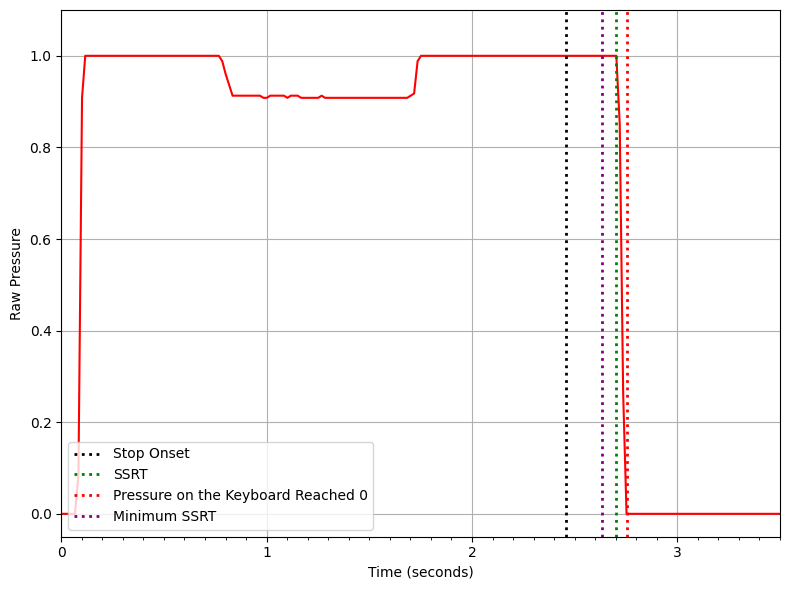

In [10]:
trial_results = shared_control_metrics['s007']['Non-AI']['trial_results']
target_trial_num = 20
trial_data = trial_results.get(target_trial_num)
plt.figure(figsize=(8, 6))
if trial_data:
    ax = plt.gca()
    plot_trial_pressure_individual(trial_data, target_trial_num, ax, color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Raw Pressure')
    plt.savefig(f'{parent_directory}/figures/figure2.png')
    plt.tight_layout()
    plt.show()

## Figure 3: Non-AI vs AI-Disengaged SSRT

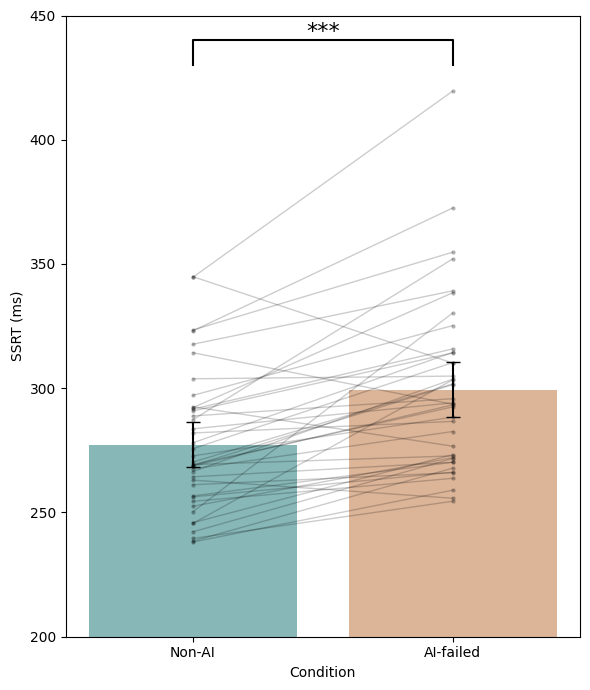

In [11]:
merged_df = merged_df.reset_index()
melted_df_ssrt = merged_df.melt(id_vars='subject_id', value_vars=['non_ai', 'ai_disengaged'],
                            var_name='Condition', value_name='SSRT')

custom_names = {
    'non_ai': 'Non-AI',
    'ai_disengaged': 'AI-failed'
}

melted_df_ssrt['Condition'] = melted_df_ssrt['Condition'].map(custom_names)

# Calculate means and confidence intervals for the conditions
summary_df = melted_df_ssrt.groupby('Condition').agg(
    Mean=('SSRT', 'mean'),
    SEM=('SSRT', stats.sem)
).reset_index()

# Calculate degrees of freedom for confidence intervals
n = melted_df_ssrt.groupby('Condition').size()
df = n - 1 
confidence_level = 0.95

ci_bounds = stats.t.interval(0.95, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

desired_order = ['Non-AI', 'AI-failed']

summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories=desired_order, ordered=True)
summary_df = summary_df.sort_values('Condition').reset_index()

plt.figure(figsize=(6, 7))

# First draw the bars
sns.barplot(data=summary_df, x='Condition', y='Mean', palette=["teal", "chocolate"], alpha=0.5)

# Add individual subject lines before the points
for subject in melted_df_ssrt['subject_id'].unique():
    subject_data = melted_df_ssrt[melted_df_ssrt['subject_id'] == subject]
    plt.plot(range(len(subject_data)), subject_data['SSRT'], 
            color='black', alpha=0.2, linewidth=1)

# Then add the points
sns.stripplot(x='Condition', y='SSRT', data=melted_df_ssrt, 
             color='black', alpha=0.3, size=3, jitter=0, zorder=2)

# Add error bars and rest of the plot elements
for index, row in summary_df.iterrows():
    plt.errorbar(x=index, y=row['Mean'], 
                yerr=[[row['Mean'] - row['CI_lower']], [row['CI_upper'] - row['Mean']]], 
                fmt='none', color='black', capsize=5)

plt.plot([0, 0, 1, 1], [430, 440, 440, 430], color='black')
plt.text(0.5, 441, "***", ha='center', fontsize=16)

# Set the title and labels
plt.ylim((200, 450))
plt.xlabel('Condition')
plt.ylabel('SSRT (ms)')

# Finalize layout and show the plot
plt.tight_layout()
plt.savefig(f'{parent_directory}/figures/figure3.png', dpi=300) 
plt.show()

## Figure 4: Non-AI vs AI-Disengaged Duration of Inhibition

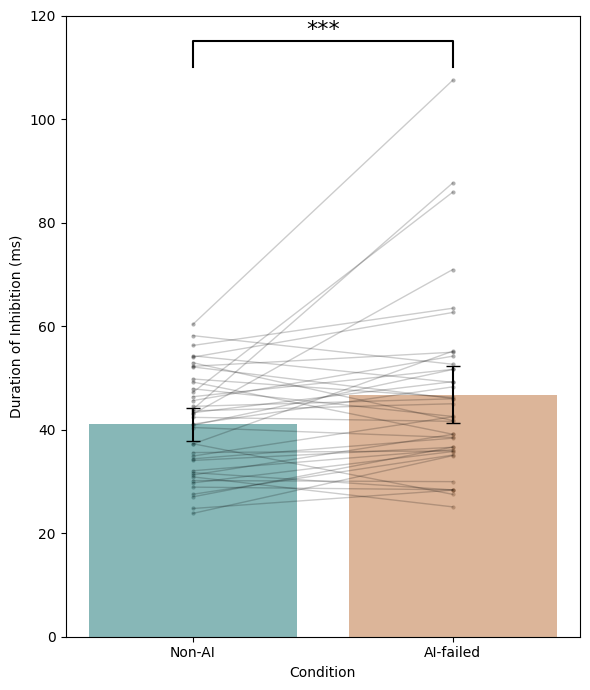

In [12]:
duration_of_inhibition = duration_of_inhibition.reset_index()
duration_of_inhibition = duration_of_inhibition.rename(columns={'index': 'subject_id'})
melted_df_duration = duration_of_inhibition.melt(id_vars='subject_id', value_vars=['non_ai', 'ai_disengaged'],
                            var_name='Condition', value_name='Duration of Inhibition')

custom_names = {
    'non_ai': 'Non-AI',
    'ai_disengaged': 'AI-failed'
}

melted_df_duration['Condition'] = melted_df_duration['Condition'].map(custom_names)

# Calculate means and confidence intervals for the conditions
summary_df = melted_df_duration.groupby('Condition').agg(
    Mean=('Duration of Inhibition', 'mean'),
    SEM=('Duration of Inhibition', stats.sem)
).reset_index()

n = melted_df_duration.groupby('Condition').size()
df = n - 1

ci_bounds = stats.t.interval(0.95, df, loc=summary_df['Mean'], scale=summary_df['SEM'])
summary_df['CI_lower'] = ci_bounds[0]
summary_df['CI_upper'] = ci_bounds[1]

n = melted_df_duration.groupby('Condition').size() 
df = n - 1 
confidence_level = 0.95

desired_order = ['Non-AI', 'AI-failed']

summary_df['Condition'] = pd.Categorical(summary_df['Condition'], categories=desired_order, ordered=True)
summary_df = summary_df.sort_values('Condition').reset_index()

plt.figure(figsize=(6, 7))

sns.barplot(data=summary_df, x='Condition', y='Mean', palette=["teal", "chocolate"], alpha=0.5)

for subject in melted_df_duration['subject_id'].unique():
    subject_data = melted_df_duration[melted_df_duration['subject_id'] == subject]
    plt.plot(range(len(subject_data)), subject_data['Duration of Inhibition'], 
            color='black', alpha=0.2, linewidth=1)

sns.stripplot(x='Condition', y='Duration of Inhibition', data=melted_df_duration, color='black', alpha=0.3, jitter=0, size=3, zorder=0)

for index, row in summary_df.iterrows():
    plt.errorbar(x=index, y=row['Mean'], 
                 yerr=[[row['Mean'] - row['CI_lower']], [row['CI_upper'] - row['Mean']]], 
                 fmt='none', color='black', capsize=5)
    
plt.plot([0, 0, 1, 1], [110, 115, 115, 110], color='black')

plt.text(0.5, 116, "***", ha='center', fontsize=16)
plt.ylim((0, 120))
plt.xlabel('Condition')
plt.ylabel('Duration of Inhibition (ms)')

plt.tight_layout()
plt.savefig(f'{parent_directory}/figures/figure4.png', dpi=300) 
plt.show()